# Algoritmo de Metrópolis

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm.notebook import tqdm
from typing import List,Callable,Dict,Union
import itertools

## Funções e Classes

### Classe da Grid do Modelo de Ising

In [3]:
class IsingGrid:
    """
    Classe que implementa uma grid 2D do modelo de Ising como um vetor 1D. 
    (Essencialmente um wrapper do np.array)
    """
    def __init__(self,n_rows:int,n_cols:int,is_torus:bool=True,
                 J_constant:float=1)->None:
        self.n_rows=n_rows
        self.n_cols=n_cols
        self.num_cells = n_rows*n_cols
        self.J_constant=J_constant
        self.is_torus = is_torus
        self.array = np.zeros(self.num_cells)
        
    def init_randint_array(self,seed:int,low:int=0,
                           high:int=2)->None:
        """
        Inicializa uma grid aleatória
        """
        np.random.seed(seed)
        self.array = np.random.randint(low=low,high=high,size=self.num_cells)
        self.array[np.where(self.array == 0)[0]] = -1
        
    def __check_input(self,row:int,col:int)->None:
        """
        Checa se o input é válido
        """
        if row >= self.n_rows or col >= self.n_cols:
            raise ValueError(f"Valor inválido para column/row ({row}/{self.n_rows},{col}/{self.n_cols})")
    
    def cell_to_row_col(self,cell:int)->Union[int,int]:
        """
        Converte um índice de célula para um par (i,j) da grid
        """
        curr_row = cell // self.n_cols
        curr_col = cell % self.n_cols

        return curr_row,curr_col

    def print_grid(self)->None:
        """
        Método print da grid
        """
        for i in range(self.n_rows):
            print(self.array[i*self.n_rows:(i+1)*self.n_rows])

    def __next__(self):
        """
        Método next
        """
        if self.iter_counter < self.num_cells:
            curr_row,curr_col = self.cell_to_row_col(self.iter_counter)
            
            self.iter_counter += 1
            
            return curr_row,curr_col
        else:
            raise StopIteration
            
    def __iter__(self):
        """
        Método iter
        """
        self.iter_counter = 0
        return self

    def copy(self):
        """
        Método que cria uma cópia do objeto
        """
        grid_copy = IsingGrid(self.n_rows,self.n_cols)
        grid_copy.array = self.array.copy()
        return grid_copy
    
    def get_cell_spin(self,row:int,col:int)->int:
        """
        Método get do spin
        """
        tgt_row = row
        tgt_col = col
        
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            if row < 0:
                tgt_row = self.n_rows-1
            elif row >= self.n_rows:
                tgt_row = 0
            
            if col < 0:
                tgt_col = self.n_cols - 1 
            elif col >= self.n_cols:
                tgt_col = 0 
            
        tgt_cell = self.n_cols * tgt_row + tgt_col
        return self.array[tgt_cell]
        
    def set_cell_spin(self,value:int,row:int,col:int)->None:
        """
        Método set do spin
        """
        if not self.is_torus:
            self.check_input(row,col)
        
        tgt_cell = self.n_cols * row + col
        self.array[tgt_cell]=value
            
    def compute_cell_partial_energy(self,row:int,col:int,
                                    flip:bool=False) -> float:
        """
        Método que computa a energia parcial de uma célula
        """
        curr_cell_spin = self.get_cell_spin(row,col)
        if flip:
            curr_cell_spin = -1 * curr_cell_spin

        up_neighbor_energy = curr_cell_spin*self.get_cell_spin(row-1,col)
        down_neighbor_energy = curr_cell_spin*self.get_cell_spin(row+1,col)
        left_neighbor_energy = curr_cell_spin*self.get_cell_spin(row,col-1)
        right_neighbor_energy = curr_cell_spin*self.get_cell_spin(row,col+1)

        partial_energy = up_neighbor_energy + down_neighbor_energy + left_neighbor_energy + right_neighbor_energy

        return partial_energy
    
    def compute_cell_neighbor_energy(self,row:int,col:int)->float:
        input_cell_spin = self.get_cell_spin(row,col)
        
        neighbors_energy = 0
        if input_cell_spin == -1:
            neighbors_energy = self.compute_cell_partial_energy(row,col,flip=True)
        else:
            neighbors_energy = self.compute_cell_partial_energy(row,col,flip=False)
        return neighbors_energy

    def compute_hamiltonian(self) -> float:
        """
        Método que computa o hamiltoniano da grid
        """
        hamiltonian = 0
        for row,col in iter(self):
            hamiltonian += self.compute_cell_partial_energy(row,col)
        return self.J_constant * hamiltonian
    

### Funções do algoritmo de Metropolis

In [6]:
def create_score_table(beta:int,
                       possible_energy_values:list=[-8,-4,0,4,8]) -> dict:
    """
    Cria a tabela(dicionário) de probabilidades para consulta
    """
    score_table = {val:np.exp((-val)*beta) for val in possible_energy_values}
    return score_table

def metropolis_monte_carlo_step(ising_grid:IsingGrid,score_table:dict,
                                     energy:int,magnetization:int,
                                     metropolis_seed:int=1234)->Union[int,int]:
    """
    Faz um passo de monte carlo de forma sequencial, i.e., percorre todas as celulas sequencialmente
    """
    energy = 0
    magnetization = 0
    for start_cell_row,start_cell_col in iter(ising_grid):
        start_cell_spin = ising_grid.get_cell_spin(start_cell_row,start_cell_col)
        
        neighbors_energy = ising_grid.compute_cell_neighbor_energy(start_cell_row,start_cell_col)

        energy_diff = 2*start_cell_spin*neighbors_energy
        energy_score = score_table[int(energy_diff)]
        
        r_value = np.random.uniform(0,1)
        if r_value <= energy_score:
            energy += energy_diff
            magnetization -= 2*start_cell_spin
            
            ising_grid.set_cell_spin(-1 * start_cell_spin,start_cell_row,start_cell_col)
    return energy,magnetization

def metropolis_monte_carlo(ising_grid:IsingGrid,metropolis_monte_carlo_step_func:Callable,
                           score_table:dict,num_monte_carlo_steps:int=1000,
                           metropolis_seed:int=1234)->Union[List[int],List[int]]:
    """
    Realiza num_monte_carlo_steps passos de monte carlo do algoritmo de metropolis
    """
    energy = ising_grid.compute_hamiltonian()
    magnetization = ising_grid.array.sum()
    
    energy_history = [energy]
    magnetization_history = [magnetization]
    
    for mc_step in range(num_monte_carlo_steps):
        curr_energy,curr_magnetization = metropolis_monte_carlo_step_func(ising_grid,score_table,
                                                                          energy,magnetization,
                                                                          metropolis_seed)
        energy += curr_energy
        magnetization += curr_magnetization
        
        energy_history.append(energy)
        magnetization_history.append(magnetization)
        
    return energy_history,magnetization_history
        
    
def run_metropolis_experiments(metropolis_monte_carlo_step_func:Callable,
                               score_table:dict,
                               num_monte_carlo_steps:int,
                               grid_seeds:list,metropolis_seed:int,
                               n_rows:int,n_cols:int,
                               temperature:float,
                               J_constant:float=1)->None:
    plt.title(f"Evolução das estatísticas do modelo(temp={temperature},size={n_rows}x{n_cols})")
    plt.xlabel("Passos de Monte Carlo")
    plt.xticks([i for i in range(0,num_monte_carlo_steps+1,100)])

    for grid_seed in tqdm(grid_seeds):
        ising_grid = IsingGrid(n_rows,n_cols,J_constant=J_constant)
        ising_grid.init_randint_array(grid_seed)

        energy_hist,magnetization_hist = metropolis_monte_carlo(ising_grid.copy(),metropolis_monte_carlo_step_func,
                                                                score_table,num_monte_carlo_steps,metropolis_seed)

        plt.plot(energy_hist,label=f'Energia(grid_seed={grid_seed})')
        plt.plot(magnetization_hist,label=f'Magnetização(grid_seed={grid_seed})')

    plt.legend()
    plt.grid()
    plt.show()

## Experimentos

In [7]:
# Constantes
boltzmann_constant = 1
J_constant = 1
possible_energy_values = [-8,-4,0,4,8]

### Experimento 1 

Nesse experimento, iremos testar duas configurações distintas iniciais. Iremos testar diversas configurações de temperatura e tamanho da grid.

  0%|          | 0/2 [00:00<?, ?it/s]

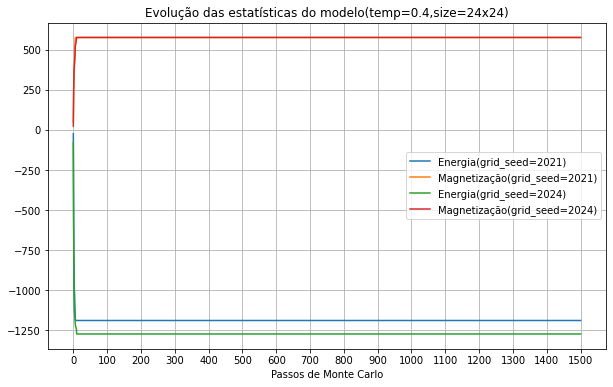

  0%|          | 0/2 [00:00<?, ?it/s]

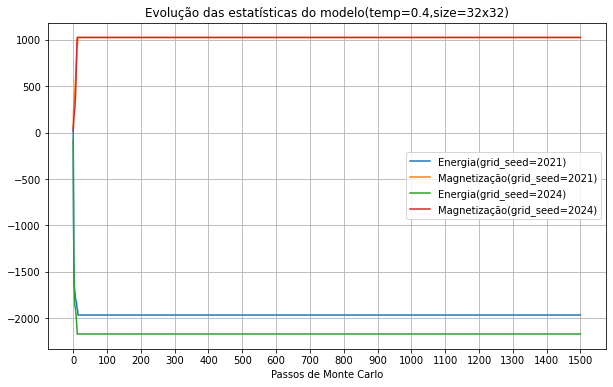

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Parâmetros do experimento
temperatures = [0.4,1.5,2,3]
sizes = [24,32,48,64]
parameter_combinations = list(itertools.product(temperatures, sizes))

num_monte_carlo_steps = 1500
metropolis_seed = 1234
grid_seeds = [2021,2024]

# Loop do experimento
for temperature,size in parameter_combinations:
    n_rows=n_cols=size

    # Inicializa a tabela de scores pré-computadas
    beta = 1/(boltzmann_constant * temperature)
    score_table = create_score_table(beta,possible_energy_values)

    # Realiza os experimentos
    run_metropolis_experiments(metropolis_monte_carlo_step,
                                   score_table,
                                   num_monte_carlo_steps,
                                   grid_seeds,metropolis_seed,
                                   n_rows,n_cols,
                                   temperature,
                                   J_constant)

In [14]:
# Tabela de resultados (criada manualmente a partir dos gráficos)
experiment_results_table = pd.DataFrame([
              ['24x24','0.4','2021',10],
              ['24x24','0.4','2024',10],
              ['32x32','0.4','2021',13],
              ['32x32','0.4','2024',13],
              ['48x48','0.4','2021',50],
              ['48x48','0.4','2024',10],
              ['64x64','0.4','2021',50],
              ['64x64','0.4','2024',50],
    
              ['24x24','1.5','2021',10],
              ['24x24','1.5','2024',10],
              ['32x32','1.5','2021',20],
              ['32x32','1.5','2024',20],
              ['48x48','1.5','2021',380],
              ['48x48','1.5','2024',1140],
              ['64x64','1.5','2021',80],
              ['64x64','1.5','2024','>1500'],
    
              ['24x24','2','2021',10],
              ['24x24','2','2024',10],
              ['32x32','2','2021',50],
              ['32x32','2','2024',50],
              ['48x48','2','2021',110],
              ['48x48','2','2024',250],
              ['64x64','2','2021',120],
              ['64x64','2','2024',1150],
    
              ['24x24','3','2021',10],
              ['24x24','3','2024',10],
              ['32x32','3','2021',10],
              ['32x32','3','2024',10],
              ['48x48','3','2021',10],
              ['48x48','3','2024',10],
              ['64x64','3','2021',10],
              ['64x64','3','2024',10],
              
             ],
             columns=['grid_size','temperature','grid_seed','num_steps_therm'])

experiment_results_table

,grid_size,temperature,grid_seed,num_steps_therm
0,24x24,0.4,2021,10
1,24x24,0.4,2024,10
2,32x32,0.4,2021,13
3,32x32,0.4,2024,13
4,48x48,0.4,2021,50
5,48x48,0.4,2024,10
6,64x64,0.4,2021,50
7,64x64,0.4,2024,50
8,24x24,1.5,2021,10
9,24x24,1.5,2024,10


*Observações e Resultados*

- Para a temperatura de 0.4, podemos observar que a termalização ocorre relativamente rápido, em menos de 50 a 100 passos de monte carlo, para todos os tamanhos de grid testados. Um caso curioso ocorre para a seed 2024 com tamanho 48x48, pois, diferentemente dos demais experimentos para essa temperatura, observamos que a magnetização se estabiliza em um valor próximo de zero. De forma geral, as energuas tendem a se estabilizar em valores negativos, enquanto a magnetização estabiliza em valores positivos.
- Para a temperatura de 1.5, observamos um comportamente mais variado. Para os tamanhos de 24x24 e 32x32, observamos que a termalização ocorre antes de 50 passos de monte carlo. No entanto, para o tamanho de 48x48, observamos que a termalização demora significamente mais para ocorrer: para a magnetização, a seed 2021 termaliza após 350 passos de monte carlo, e a seed 2024 após 1150 passos de monte carlo, enquanto para a magnetização ambas as seeds precisaram de cerca de 1150 passos de monte carlo para termalizar. Para o tamanho de 64x64, observamos que para a seed 2021, tanto a magnetização quanto a energia termalizaram antes de 100 passos de monte carlo, mas para a seed 2024, apesar de sua energia ter estabilizado também antes de 100 passos, sua magnetização não conseguiu estabilizar com menos de 1500 passos (que é o limite estabelecido no teste).
- Para a temperatura de 2, nos tamanhos de 24x24 e 32x32, observamos que a termalização ocorre antes de 100 passos de monte carlo. Para o tamanho de 48x48, a termalização da seed 2021 ocorre antes de 200 passos de monte carlo, enquanto para a seed 2024 ocorre antes de 300 passos. Para o tamanho de 64x64, obseramos um fenômeno interessante para a seed 2021 na sua magnetização: o método aparenta ter encontrado um mínimo local com 400 passos, mas então prossegue para diminuir seu valor após 1100 passos, indicando que o método encontrou um valor estável menor. A energia de ambas as seeds nesse caso também estabilizou antes de 200 passos, bem como a magnetização da seed 2024.
- Para a temperatura 3, observamos que, independentemente do tamanho da grid, a termalização ocorre relativamente rápido, no entanto, existem flutuações consideráveis nos valores estáveis obtidos, e.g., a magnetização estabiliza numa faixa de -200 a 200, flutuando os valores nesse intervalo a cada iteração.

### Experimento 2

Nesse experimento, iremos testar uma grid que inicialmente tem todos os spins para cima para diferentes valores de temperatura e tamanho de grid.

  0%|          | 0/2 [00:00<?, ?it/s]

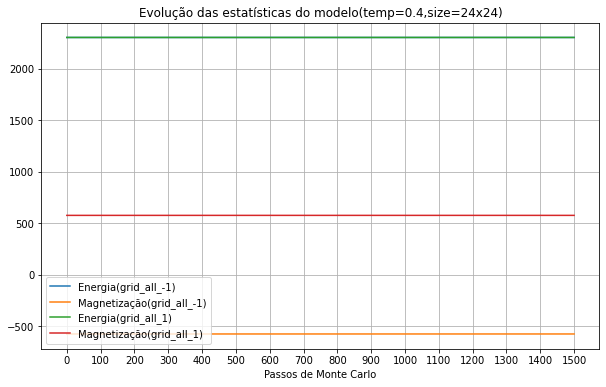

  0%|          | 0/2 [00:00<?, ?it/s]

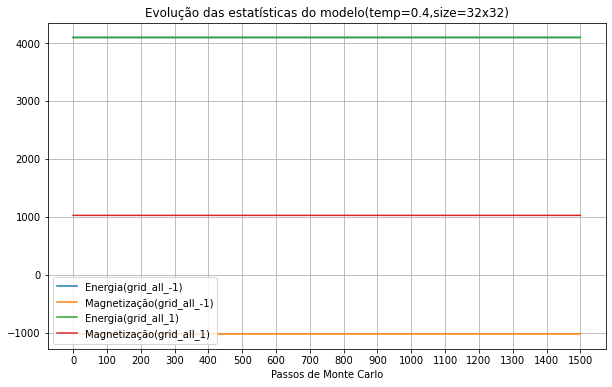

  0%|          | 0/2 [00:00<?, ?it/s]

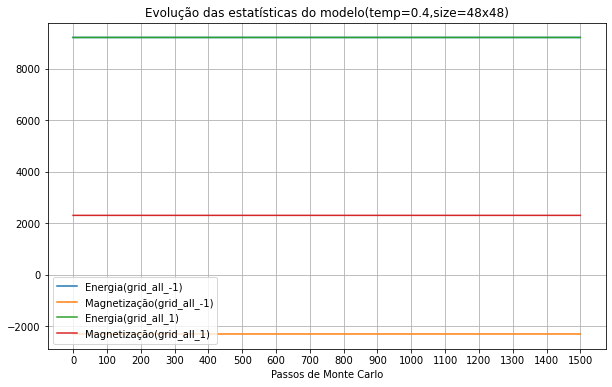

  0%|          | 0/2 [00:00<?, ?it/s]

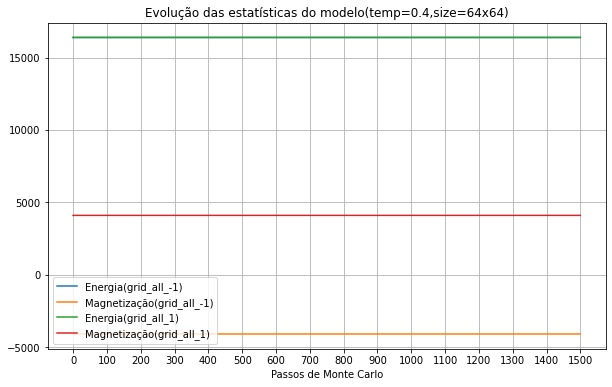

  0%|          | 0/2 [00:00<?, ?it/s]

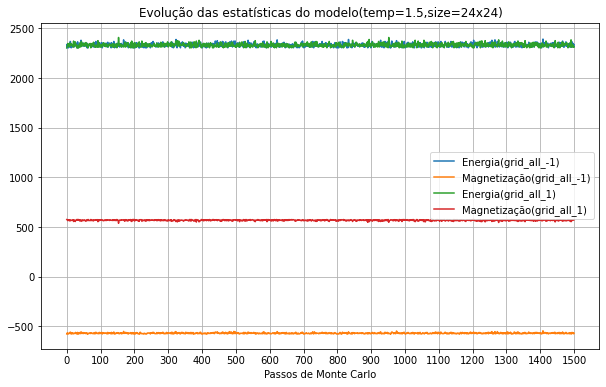

  0%|          | 0/2 [00:00<?, ?it/s]

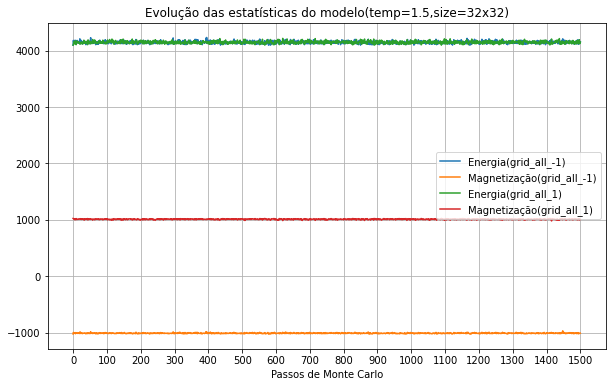

  0%|          | 0/2 [00:00<?, ?it/s]

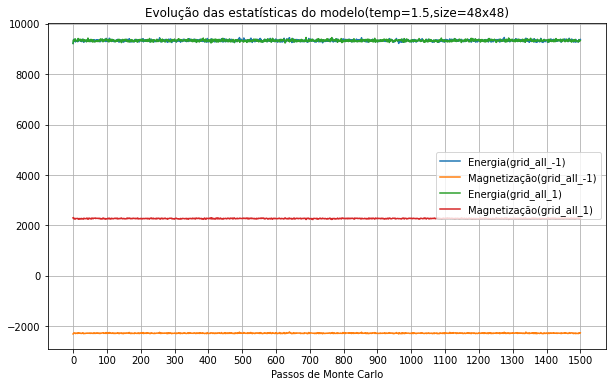

  0%|          | 0/2 [00:00<?, ?it/s]

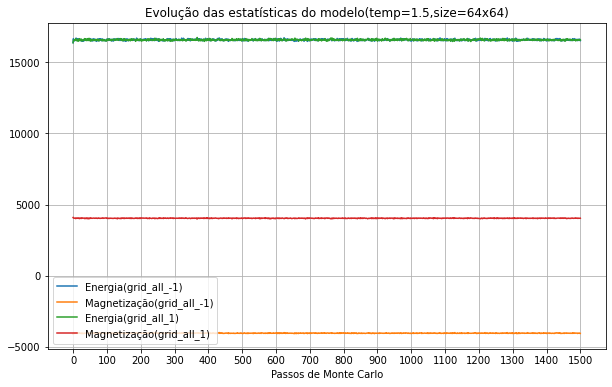

  0%|          | 0/2 [00:00<?, ?it/s]

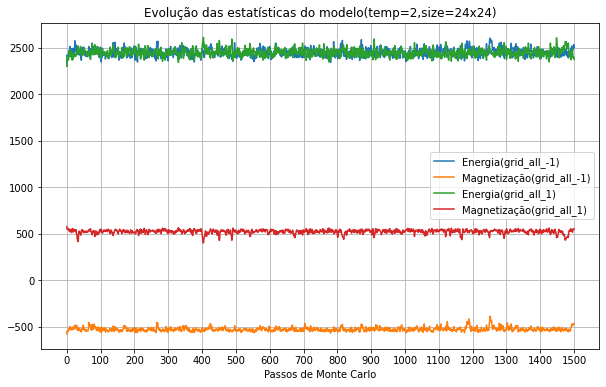

  0%|          | 0/2 [00:00<?, ?it/s]

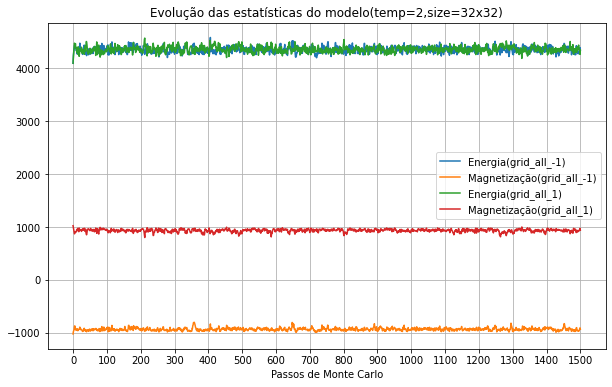

  0%|          | 0/2 [00:00<?, ?it/s]

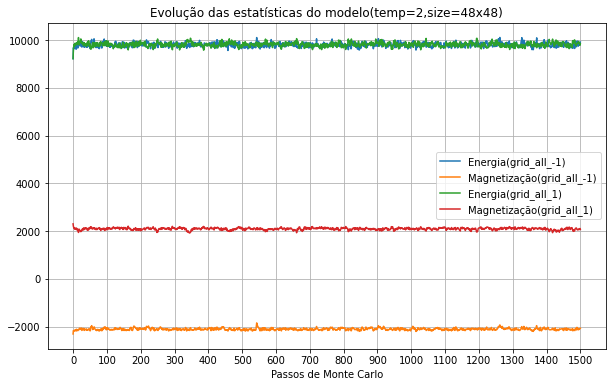

  0%|          | 0/2 [00:00<?, ?it/s]

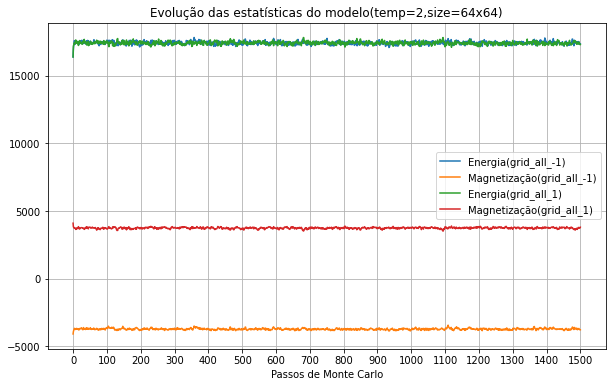

  0%|          | 0/2 [00:00<?, ?it/s]

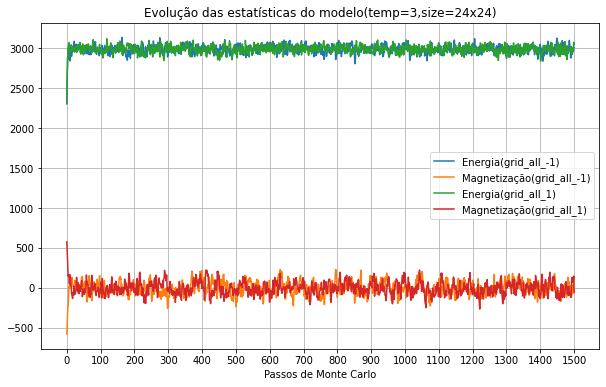

  0%|          | 0/2 [00:00<?, ?it/s]

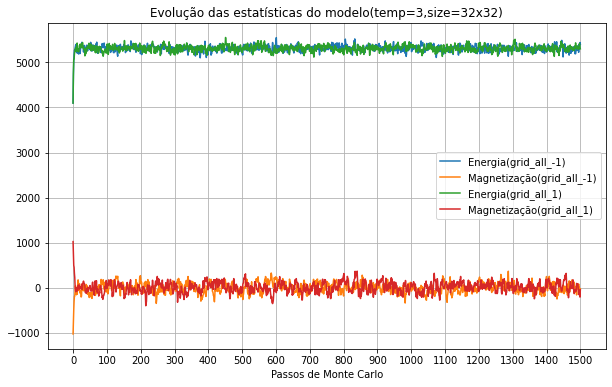

  0%|          | 0/2 [00:00<?, ?it/s]

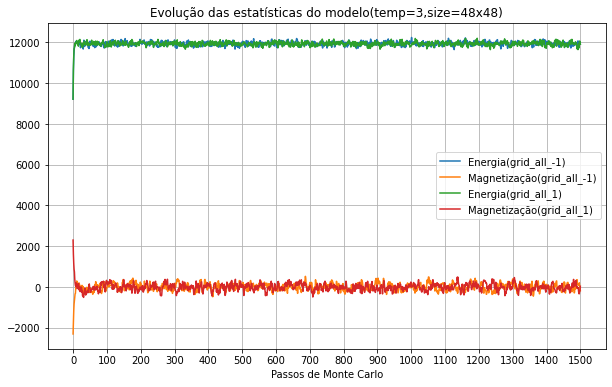

  0%|          | 0/2 [00:00<?, ?it/s]

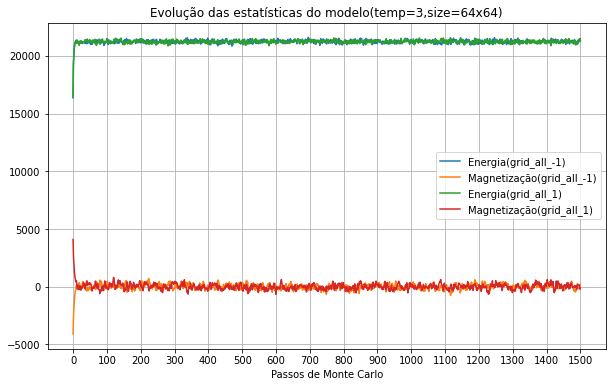

In [6]:
# Parâmetros do experimento
temperatures = [0.4,1.5,2,3]
sizes = [24,32,48,64]
parameter_combinations = list(itertools.product(temperatures, sizes))

num_monte_carlo_steps = 1500
metropolis_seed = 1234

# Loop do experimento
for temperature,size in parameter_combinations:
    n_rows=n_cols=size

    # Inicializa a tabela de scores pré-computadas
    beta = 1/(boltzmann_constant * temperature)
    score_table = create_score_table(beta,possible_energy_values)

    # Realiza os experimentos
    plt.title(f"Evolução das estatísticas do modelo(temp={temperature},size={n_rows}x{n_cols})")
    plt.xlabel("Passos de Monte Carlo")
    plt.xticks([i for i in range(0,num_monte_carlo_steps+1,100)])
    
    for i in tqdm([-1,1]):
        ising_grid = IsingGrid(n_rows,n_cols,J_constant=J_constant)
        ising_grid.array = i * np.ones(ising_grid.num_cells)

        energy_hist,magnetization_hist = metropolis_monte_carlo(ising_grid.copy(),metropolis_monte_carlo_step,
                                                                score_table,num_monte_carlo_steps,metropolis_seed)

        plt.plot(energy_hist,label=f'Energia(grid_all_{i})')
        plt.plot(magnetization_hist,label=f'Magnetização(grid_all_{i})')

    plt.legend()
    plt.grid()
    plt.show()

*Observações e Resultados*

- Para o segundo experimento, assim como esperado, observamos que para temperaturas baixas (0.4 e 1.5), a termalização ocorre instantâneamente, pois a grid já é inicializada com valores de spins todos iguais (todos -1 ou todos 1), e portanto em tais temperaturas a probabilidade de um flip no spin é menor, resultando em um sistema que já começa estável e fica assim indefinidamente, independente do tamanho de tal grid. 
- Para temperaturas maiores (2 e 3), observamos flutuações maiores nos valores de estabilidade para todos os tamanhos de grid, mais especificamente, para a temperatura de de 3, observamos que os valores não se inicializam no estável, demorando pouco menos de 10 passos de monte carlo para alcançar a termalização.